 # IMDB Dataset: EDA & Preprocessing
# This notebook performs exploratory data analysis and cleaning on the IMDB sentiment review dataset to prepare it for modeling.



## 1. Setup
Importing necessary libraries.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from nltk.corpus import stopwords
from wordcloud import WordCloud
import re
import nltk

nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))

## 2. Load Data
Loading the raw IMDB dataset.

In [2]:
df = pd.read_csv("../data/raw_imdb_dataset.csv")

## 3. Initial Exploration
Checking the shape, missing values, and duplicates.

In [3]:
print("Shape:", df.shape)
print("Missing values:\n", df.isnull().sum())
print("Duplicates:", df.duplicated().sum())
df.head(5)

Shape: (50000, 2)
Missing values:
 review       0
sentiment    0
dtype: int64
Duplicates: 418


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## 4. Sentiment Distribution and Word Count

In [4]:
# Create filtered DataFrames
good_reviews = df[df['sentiment'] == 'positive']
bad_reviews = df[df['sentiment'] == 'negative']

# Get word counts
count_good_words = good_reviews['review'].str.split().apply(len)
count_bad_words = bad_reviews['review'].str.split().apply(len)


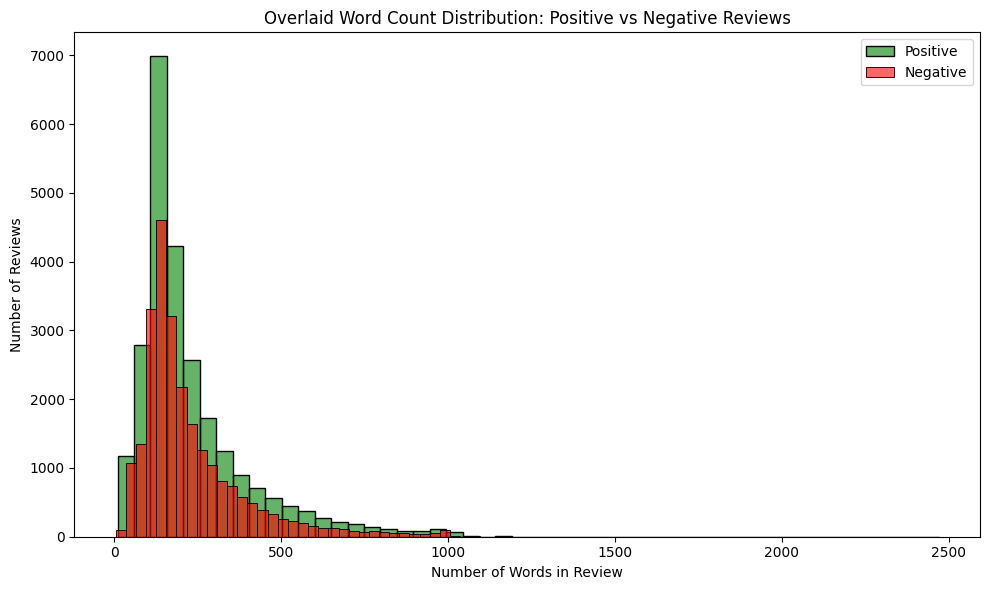

In [5]:
plt.figure(figsize=(10, 6))
sns.histplot(count_good_words, color='green', label='Positive', bins=50, kde=False, stat="count", alpha=0.6)
sns.histplot(count_bad_words, color='red', label='Negative', bins=50, kde=False, stat="count", alpha=0.6)

plt.title('Overlaid Word Count Distribution: Positive vs Negative Reviews')
plt.xlabel('Number of Words in Review')
plt.ylabel('Number of Reviews')
plt.legend()
plt.tight_layout()
plt.show()

## 5. Review Length Buckets

Shows how sentiment correlates with length buckets.

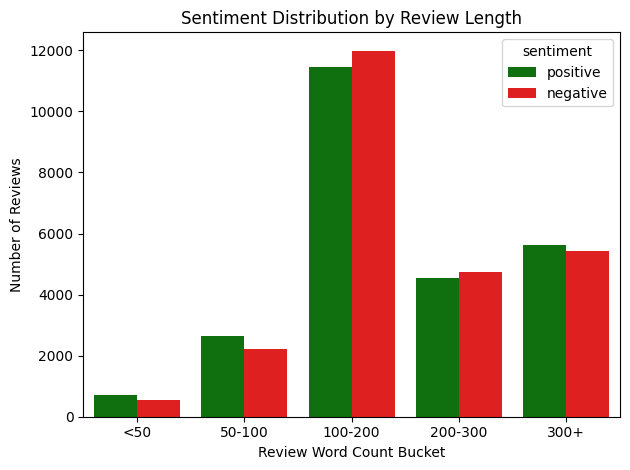

In [6]:
df['word_count'] = df['review'].str.split().apply(len)


df['length_bucket'] = pd.cut(df['word_count'], bins=[0, 50, 100, 200, 300, 1000], labels=['<50', '50-100', '100-200', '200-300', '300+'])
sns.countplot(data=df, x='length_bucket', hue='sentiment', palette={'positive': 'green', 'negative': 'red'})
plt.title("Sentiment Distribution by Review Length")
plt.xlabel("Review Word Count Bucket")
plt.ylabel("Number of Reviews")
plt.tight_layout()
plt.show()

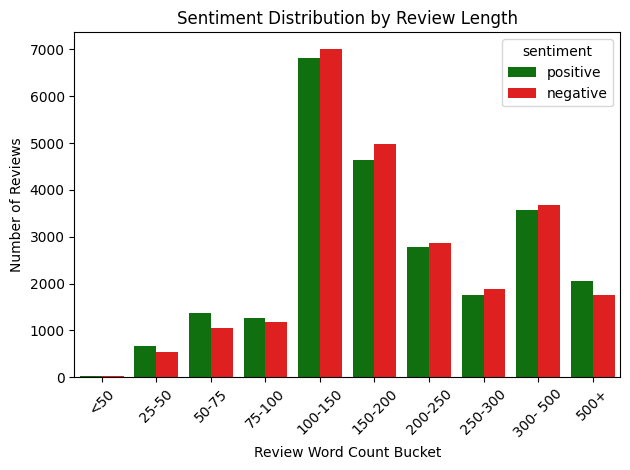

In [7]:
#different bucket sizes

df['word_count'] = df['review'].str.split().apply(len)


df['length_bucket'] = pd.cut(df['word_count'], bins=[0, 25, 50, 75, 100, 150, 200, 250, 300, 500, 1000], labels=['<50', '25-50', '50-75', '75-100', '100-150', '150-200', '200-250', '250-300', '300- 500', '500+'])
sns.countplot(data=df, x='length_bucket', hue='sentiment', palette={'positive': 'green', 'negative': 'red'})
plt.title("Sentiment Distribution by Review Length")
plt.xlabel("Review Word Count Bucket")
plt.xticks(rotation = 45)
plt.ylabel("Number of Reviews")
plt.tight_layout()
plt.show()

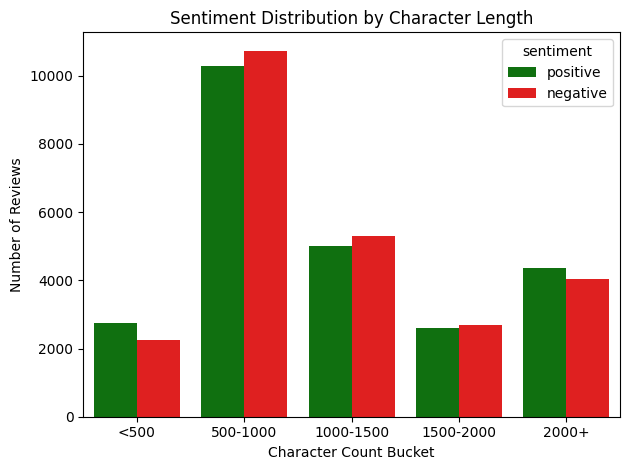

In [8]:
df['char_count'] = df['review'].apply(len)
df['char_length_bucket'] = pd.cut(df['char_count'], bins=[0, 500, 1000, 1500, 2000, 10000],
                                  labels=['<500', '500-1000', '1000-1500', '1500-2000', '2000+'])

sns.countplot(data=df, x='char_length_bucket', hue='sentiment',
              palette={'positive': 'green', 'negative': 'red'})
plt.title("Sentiment Distribution by Character Length")
plt.xlabel("Character Count Bucket")
plt.ylabel("Number of Reviews")
plt.tight_layout()
plt.show()


## 6. Word Frequency and WordCloud

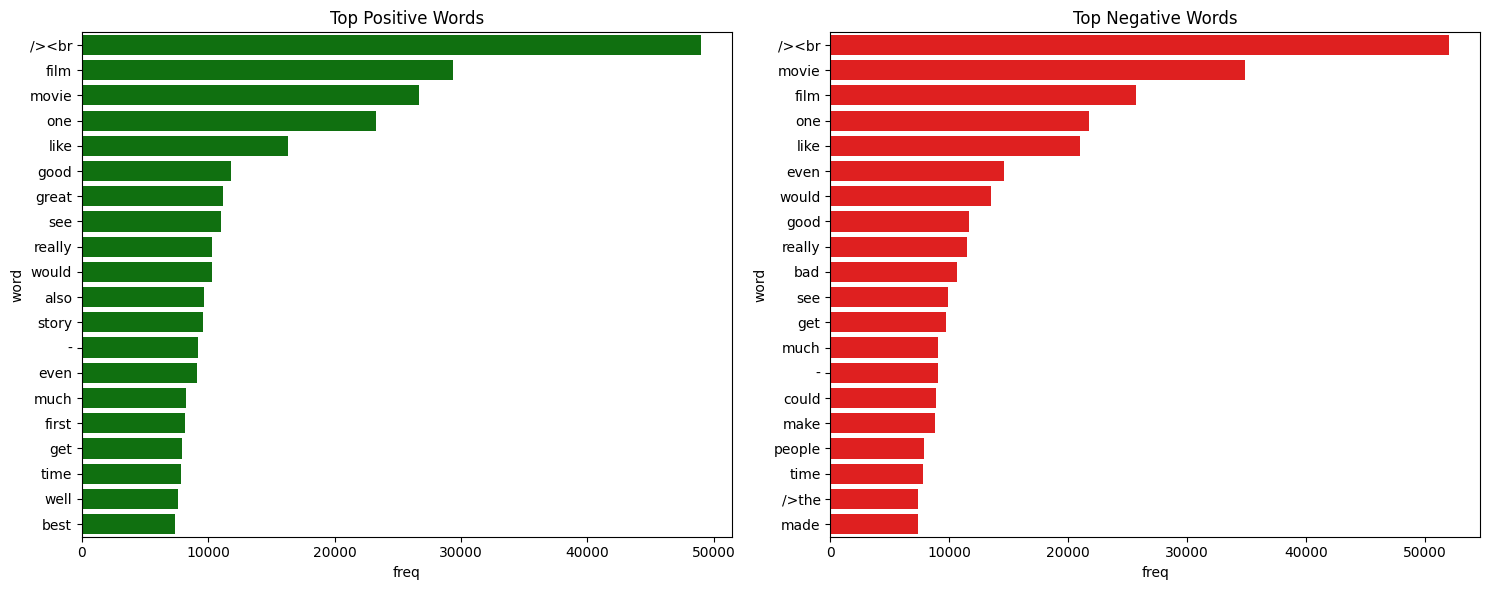

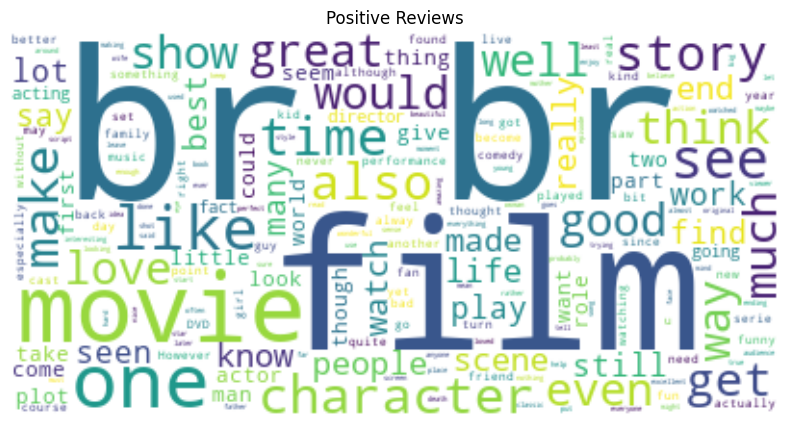

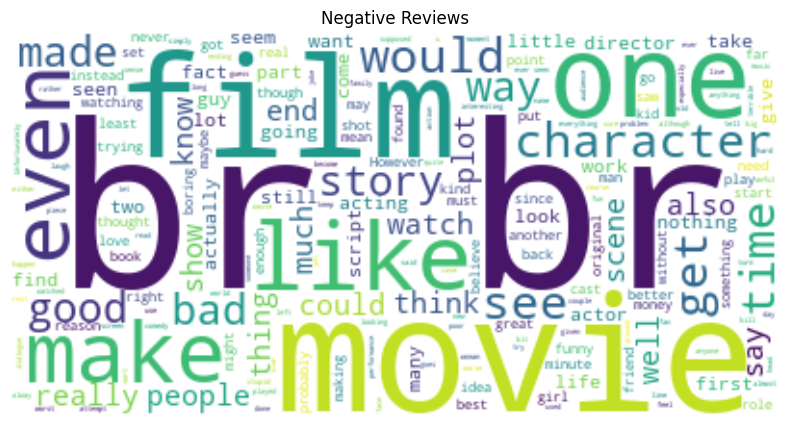

In [9]:
def get_top_n_words(corpus, n=None):
    words = [word for review in corpus for word in review.lower().split() if word not in stop_words]
    word_freq = Counter(words)
    return word_freq.most_common(n)

good_reviews = df[df['sentiment'] == 'positive']['review']
bad_reviews = df[df['sentiment'] == 'negative']['review']

top_pos = get_top_n_words(good_reviews, 20)
top_neg = get_top_n_words(bad_reviews, 20)

# Convert to DataFrame
top_pos_df = pd.DataFrame(top_pos, columns=['word', 'freq'])
top_neg_df = pd.DataFrame(top_neg, columns=['word', 'freq'])

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
sns.barplot(x='freq', y='word', data=top_pos_df, ax=axs[0], color='green')
axs[0].set_title("Top Positive Words")
sns.barplot(x='freq', y='word', data=top_neg_df, ax=axs[1], color='red')
axs[1].set_title("Top Negative Words")
plt.tight_layout()
plt.show()

# WordClouds
def show_wordcloud(text, title=None):
    wordcloud = WordCloud(background_color='white', stopwords=stop_words, max_words=200).generate(' '.join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()

show_wordcloud(good_reviews, "Positive Reviews")
show_wordcloud(bad_reviews, "Negative Reviews")

## 7. Data Quality Flags

In [10]:
sample_with_html = df[df['review'].str.contains(r'<[^>]+>')]
print(f"Reviews with HTML tags: {len(sample_with_html)}")

very_short = df[df['word_count'] < 3]
print(f"Very short reviews (less than 3 words): {len(very_short)}")


Reviews with HTML tags: 29202
Very short reviews (less than 3 words): 0


## 8. Cleaning Functions
Apply regex-based cleaning for punctuation, HTML, URLs, and emojis.

In [11]:
def remove_punctuations(data):
    return re.sub(r'[^\w\s]', '', data)

def remove_html(data):
    # Remove actual HTML tags
    data = re.sub(r'<.*?>', '', data)
    # Also remove leftover HTML artifacts like 'br', 'br/', or standalone 'br'
    data = re.sub(r'\bbr\b|br/|/br', '', data, flags=re.IGNORECASE)
    return data

def remove_url(data):
    return re.sub(r"https://\S+|www\.\S+", '', data)

def remove_emoji(data):
    emoji_clean = re.compile("["
                           u"\U0001F600-\U0001F64F"
                           u"\U0001F300-\U0001F5FF"
                           u"\U0001F680-\U0001F6FF"
                           u"\U0001F1E0-\U0001F1FF"
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_clean.sub(r'', data)

# Apply cleaning
for func in [remove_punctuations, remove_html, remove_url, remove_emoji]:
    df['review'] = df['review'].apply(func)

# Drop duplicates again after cleaning
df.drop_duplicates(subset='review', inplace=True)


## 9. Final Dataset Overview

In [12]:
print("Final shape:", df.shape)
print(df['sentiment'].value_counts())
df.head()

Final shape: (49581, 6)
sentiment
positive    24884
negative    24697
Name: count, dtype: int64


,review,sentiment,word_count,length_bucket,char_count,char_length_bucket
0,One of the other reviewers has mentioned that ...,positive,307,300- 500,1761,1500-2000
1,A wonderful little production The filming te...,positive,162,150-200,998,500-1000
2,I thought this was a wonderful way to spend ti...,positive,166,150-200,926,500-1000
3,Basically theres a family where a little boy J...,negative,138,100-150,748,500-1000
4,Petter Matteis Love in the Time of Money is a ...,positive,230,200-250,1317,1000-1500


In [13]:
# Save cleaned data to processed folder
df.to_csv("../data/clean_imdb_dataset.csv", index=False)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yasminebenmessaoud/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


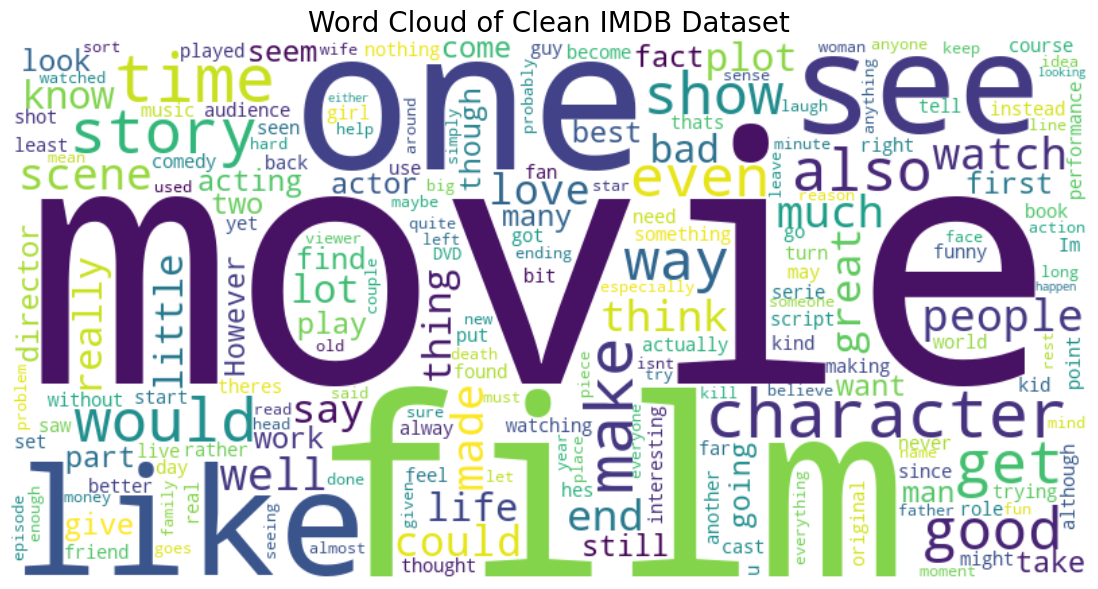

In [ ]:
# Load cleaned dataset
df_clean = pd.read_csv("../data/clean_imdb_dataset.csv")

# Combine all reviews into one large string
all_text = ' '.join(df_clean['review'].dropna())

# Get English stopwords
stop_words = set(stopwords.words('english'))

# Generate word cloud
wordcloud = WordCloud(
    width=800, height=400,
    background_color='white',
    stopwords=stop_words,
    max_words=200
).generate(all_text)

# Display
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Clean IMDB Dataset", fontsize=20)
plt.show()
